In [3]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

etfs = pd.read_csv('etfs/filtered_etfs.csv', header = None, names = ['ETF'], skiprows = [0])

tickers = etfs["ETF"].tolist()

start_date = '2015-01-01'
end_date = '2020-01-01'

data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]

prices = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_35699/537642224.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  62 of 62 completed


In [ ]:
# rolling cointegration

window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
cointegrated_pairs_df.head()

ETF1: IWS, ETF2: VYM, Pass %: 0.14583333333333334
ETF1: IWS, ETF2: SDY, Pass %: 0.14583333333333334
ETF1: IWS, ETF2: MTUM, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: IUSV, Pass %: 0.2916666666666667
ETF1: IWS, ETF2: IWN, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: SPHD, Pass %: 0.0625
ETF1: IWS, ETF2: VTV, Pass %: 0.2708333333333333
ETF1: IWS, ETF2: DGRO, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: SPLG, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: USMV, Pass %: 0.0625
ETF1: IWS, ETF2: MDY, Pass %: 0.3541666666666667
ETF1: IWS, ETF2: SCHX, Pass %: 0.0625
ETF1: IWS, ETF2: FV, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: SCHV, Pass %: 0.22916666666666666
ETF1: IWS, ETF2: IWD, Pass %: 0.3125
ETF1: IWS, ETF2: SCHA, Pass %: 0.10416666666666667
ETF1: IWS, ETF2: VTWO, Pass %: 0.041666666666666664
ETF1: IWS, ETF2: SCHD, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: SPY, Pass %: 0.10416666666666667
ETF1: IWS, ETF2: DVY, Pass %: 0.2708333333333333
ETF1: IWS, ETF2: IJR, Pass %: 0.0416666666666

,ETF1,ETF2,Pass %
0,IWM,SPSM,0.770833
1,SPLG,IWB,0.750000
2,SPY,VOO,0.750000
3,IVW,SPYG,0.750000
4,VTWO,SPSM,0.750000


In [26]:
category_prices = prices[tickers]
returns = category_prices.pct_change().dropna()

In [29]:
import numpy as np
import statsmodels.api as sm

CORR_252_MAX = 0.98
CORR_060_MAX = 0.98
CORR_252_MIN = 0.3
CORR_060_MIN = 0.3
USE_ABS_CORR = True

def trailing_corr(returns, t1, t2, window):
    r1 = returns[t1].dropna()
    r2 = returns[t2].dropna()
    r = pd.concat([r1, r2], axis=1, join='inner').dropna()
    if len(r) < window:
        return np.nan
    c = r.iloc[-window:].corr().iloc[0,1]
    return abs(c) if USE_ABS_CORR else c

def apply_corr_filter(cointegrated_pairs_df, returns):
    rows = []
    for t1, t2 in cointegrated_pairs_df[['ETF1','ETF2']].itertuples(index=False):
        c252 = trailing_corr(returns, t1, t2, 252)
        c060 = trailing_corr(returns, t1, t2, 60)
        keep = (CORR_252_MIN <= c252 <= CORR_252_MAX) and (CORR_060_MIN <= c060 <= CORR_060_MAX)
        rows.append({'ETF1': t1, 'ETF2': t2, 'corr_252': c252, 'corr_060': c060, 'keep_corr': keep})
    metrics = pd.DataFrame(rows)

    out = cointegrated_pairs_df.merge(metrics, on=['ETF1','ETF2'], how='left')
    filtered = out[out['keep_corr']].sort_values(by=['corr_252','corr_060'])
    return filtered, out

corr_filtered_pairs_df, corr_metrics_df = apply_corr_filter(cointegrated_pairs_df, returns)
print("Kept after correlation filter:", len(corr_filtered_pairs_df), "of", len(cointegrated_pairs_df))
corr_filtered_pairs_df.head(19)

Kept after correlation filter: 16 of 32


,Unnamed: 0,ETF1,ETF2,Pass %,corr_252,corr_060,keep_corr
26,26,DVY,OEF,0.437500,0.884540,0.853551,True
21,21,DVY,IWR,0.479167,0.917135,0.895396,True
31,31,VO,DIA,0.416667,0.918764,0.850306,True
23,23,IWR,DIA,0.458333,0.919129,0.864058,True
28,28,VTV,SPHQ,0.437500,0.921767,0.888828,True
22,22,SCHV,SPHQ,0.479167,0.929327,0.900711,True
25,25,RSP,DIA,0.437500,0.935973,0.884363,True
30,30,DVY,FVD,0.416667,0.942537,0.909541,True
29,29,DVY,VYM,0.416667,0.959562,0.939250,True
12,12,VO,SPY,0.541667,0.971672,0.965413,True


Clusters:
     ETF  Cluster        PC1        PC2
0    IWS        1   3.915001 -15.992467
1    VYM        1  18.262669  -2.312954
2    SDY        1  17.521994 -12.516774
3   MTUM        1   2.741444  27.573357
4   IUSV        1   9.129327  -8.510958
..   ...      ...        ...        ...
57  VLUE        1  -1.431810  -5.469642
58   DIA        1  14.101379   7.141703
59  SPYV        1  11.523447  -7.111809
60   IWP        1 -11.397252   8.072674
61   VOO        1   6.516640   9.216728

[62 rows x 4 columns]


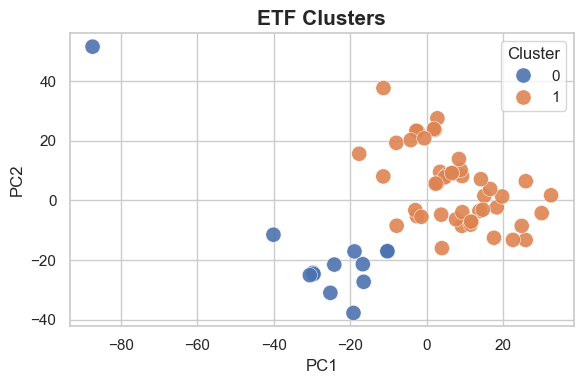

In [30]:
# k-means / PCA

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 3
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'ETF Clusters', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [31]:
final_candidates = []

cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for _, row in corr_filtered_pairs_df.iterrows():
    etf1, etf2, pass_percentage = row['ETF1'], row['ETF2'], row['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.append([etf1, etf2, pass_percentage, cluster_zip[etf1]])

final_candidates = pd.DataFrame(final_candidates, columns=['ETF1', 'ETF2', 'RC Pass %', 'Cluster #'])
final_candidates = final_candidates.sort_values('RC Pass %', ascending = False).reset_index(drop = True)
print(final_candidates)


    ETF1  ETF2  RC Pass %  Cluster #
0     VO   IWB   0.583333          1
1     VO   SPY   0.541667          1
2     VO  SCHX   0.520833          1
3     VO  SPLG   0.520833          1
4     VO   IVV   0.500000          1
5     VO   VOO   0.500000          1
6    DVY   IWR   0.479167          1
7   SCHV  SPHQ   0.479167          1
8    IWR   DIA   0.458333          1
9    DVY   OEF   0.437500          1
10   VTV  SPHQ   0.437500          1
11   RSP   DIA   0.437500          1
12    VO   DIA   0.416667          1
13   DVY   FVD   0.416667          1
14   DVY   VYM   0.416667          1
